In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
import corner
import matplotlib.cm as cm

import matplotlib.mlab as mlab

%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','ca_ratio', 'ba_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [4]:
in_path = "../data/illustris1_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_illu, MW_sim_vmax_sorted_illu = load_experiment(input_path=in_path, fixed_number=False)

in_path = "../data/illustris1dark_mstar_selected_summary//vmax_sorted/"
M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm = load_experiment(input_path=in_path, fixed_number=False)

in_path = "../data/elvis_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis = load_experiment(input_path=in_path, fixed_number=False)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted, MW_obs_vmag_sorted = load_experiment(input_path=in_path, fixed_number=False, full_data=False)



[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20
[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1, 20, 21, 22, 23, 25, 2, 3, 4, 5, 6, 7, 8, 9] 24
[0, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9] 12
[0] 1


In [5]:
def points_in_experiment(experiment):
    keys = list(experiment.keys())
    n_points = len(experiment[keys[0]])
    return n_points

In [6]:
def copy_experiment(experiment, id_to_remove=None):
    copy = {}
    n_points = points_in_experiment(experiment)
    for k in experiment.keys():
        if id_to_remove is None:
            copy[k] = experiment[k].copy()
        else:
            ii = np.arange(n_points)
            copy[k] = experiment[k][ii!=id_to_remove]
    return copy

In [7]:
def get_data_obs(obs_data):
    fields = {0:'width', 1:'ca_ratio', 2:'ba_ratio'}
    n_fields = len(fields)
    data_obs = np.zeros((n_fields, len(obs_data['width'])))

    for i in range(n_fields):
        field = fields[i]
        x_obs = (obs_data[field] - obs_data[field+'_random'])/obs_data[field+'_random_sigma']
        data_obs[i,:] = x_obs[:]
    
    return {'data_obs': data_obs, 'fields':fields}

In [8]:
def covariance_and_mean(experiment):
    fields = {0:'width', 1:'ca_ratio', 2:'ba_ratio'}
    n_fields = len(fields)
    n_points = points_in_experiment(experiment)
    data_sim = np.zeros((n_fields, n_points))
    for i in range(n_fields):
        field = fields[i]
        x_sim = (experiment[field] - experiment[field+'_random'])/experiment[field+'_random_sigma']
        data_sim[i,:] = x_sim[:]
    
    data_cov = np.cov(data_sim)
    data_mean = np.mean(data_sim, axis=1)

    return {'covariance':data_cov, 'mean':data_mean, 'fields':fields}

In [9]:
def jacknife_covariance(experiment):
    cov_and_mean = {}
    n_points = points_in_experiment(experiment)
    for i in range(n_points):
        tmp = copy_experiment(experiment, id_to_remove=i)
        cov_and_mean[i] = covariance_and_mean(tmp)
        
    covariance_avg = cov_and_mean[0]['covariance'] - cov_and_mean[0]['covariance']
    for i in range(n_points):
        covariance_avg += cov_and_mean[i]['covariance']
    covariance_avg = covariance_avg/n_points

    covariance_std = cov_and_mean[0]['covariance'] - cov_and_mean[0]['covariance']
    for i in range(n_points):
        covariance_std += (cov_and_mean[i]['covariance']-covariance_avg)**2
    covariance_std = np.sqrt(covariance_std/n_points)
    
    mean_avg = cov_and_mean[0]['mean'] - cov_and_mean[0]['mean']
    for i in range(n_points):
        mean_avg += cov_and_mean[i]['mean']
    mean_avg = mean_avg/n_points

    mean_std = cov_and_mean[0]['mean'] - cov_and_mean[0]['mean']
    for i in range(n_points):
        mean_std += (cov_and_mean[i]['mean'] - mean_avg)**2
    mean_std = np.sqrt(mean_std/20)
    
    
    return {'covariance': covariance_avg, 'covariance_error': covariance_std, 'mean': mean_avg, 'mean_error': mean_std}

In [10]:
cov_illustris_M31 = jacknife_covariance(M31_sim_vmax_sorted_illu)
cov_illustris_MW = jacknife_covariance(MW_sim_vmax_sorted_illu)

cov_illustrisdm_M31 = jacknife_covariance(M31_sim_vmax_sorted_illudm)
cov_illustrisdm_MW = jacknife_covariance(MW_sim_vmax_sorted_illudm)

cov_elvis_M31 = jacknife_covariance(M31_sim_vmax_sorted_elvis)
cov_elvis_MW = jacknife_covariance(MW_sim_vmax_sorted_elvis)

M31_obs = get_data_obs(M31_obs_vmag_sorted)
MW_obs = get_data_obs(MW_obs_vmag_sorted)

In [11]:
print("\nM31\n====\n")
print("\n Illustris")
print(cov_illustris_M31['covariance'])
print(cov_illustris_M31['covariance_error'])
print(cov_illustris_M31['mean'])
print(cov_illustris_M31['mean_error'])


print("\nMW\n====\n")
print("\n Illustris")
print(cov_illustris_MW['covariance'])
print(cov_illustris_MW['covariance_error'])
print(cov_illustris_MW['mean'])
print(cov_illustris_MW['mean_error'])


print("\nM31\n====\n")
print("\n IllustrisDM")
print(cov_illustrisdm_M31['covariance'])
print(cov_illustrisdm_M31['covariance_error'])
print(cov_illustrisdm_M31['mean'])
print(cov_illustrisdm_M31['mean_error'])


print("\nMW\n====\n")
print("\n IllustrisDM")
print(cov_illustrisdm_MW['covariance'])
print(cov_illustrisdm_MW['covariance_error'])
print(cov_illustrisdm_MW['mean'])
print(cov_illustrisdm_MW['mean_error'])


print("\nM31\n====\n")
print("\n Elvis")
print(cov_elvis_M31['covariance'])
print(cov_elvis_M31['covariance_error'])
print(cov_elvis_M31['mean'])
print(cov_elvis_M31['mean_error'])


print("\nMW\n====\n")
print("\n Elvis")
print(cov_elvis_MW['covariance'])
print(cov_elvis_MW['covariance_error'])
print(cov_elvis_MW['mean'])
print(cov_elvis_MW['mean_error'])


M31
====


 Illustris
[[ 0.90258597  0.73110639  0.57797407]
 [ 0.73110639  0.89167474  0.06811052]
 [ 0.57797407  0.06811052  0.96178963]]
[[ 0.03566939  0.04213317  0.04034687]
 [ 0.04213317  0.05288141  0.03807167]
 [ 0.04034687  0.03807167  0.04736469]]
[-0.16209639 -0.27218206 -0.31909784]
[ 0.04873629  0.04844081  0.0503093 ]

MW
====


 Illustris
[[ 0.69046586  0.67588946  0.23891775]
 [ 0.67588946  0.96292042 -0.14684286]
 [ 0.23891775 -0.14684286  0.61519836]]
[[ 0.05921684  0.07101785  0.03421725]
 [ 0.07101785  0.08701323  0.04087582]
 [ 0.03421725  0.04087582  0.04811115]]
[-0.23094149 -0.55480638 -0.1522165 ]
[ 0.04262646  0.05033886  0.04023609]

M31
====


 IllustrisDM
[[ 1.60784425  1.34430625  0.66496212]
 [ 1.34430625  1.35631466  0.28038264]
 [ 0.66496212  0.28038264  0.74312149]]
[[ 0.09095409  0.089858    0.0443649 ]
 [ 0.089858    0.08712154  0.041231  ]
 [ 0.0443649   0.041231    0.04894246]]
[-0.35741949 -0.54284141 -0.15071469]
[ 0.05912118  0.05430019  0.0401

In [12]:
data_random_elvis_M31 = np.random.multivariate_normal(cov_elvis_M31['mean'], cov_elvis_M31['covariance'], size=100000)
data_random_illustris_M31 = np.random.multivariate_normal(cov_illustris_M31['mean'], cov_illustris_M31['covariance'], size=100000)
data_random_illustrisdm_M31 = np.random.multivariate_normal(cov_illustrisdm_M31['mean'], cov_illustrisdm_M31['covariance'], size=100000)


data_random_elvis_MW = np.random.multivariate_normal(cov_elvis_MW['mean'], cov_elvis_MW['covariance'], size=100000)
data_random_illustris_MW = np.random.multivariate_normal(cov_illustris_MW['mean'], cov_illustris_MW['covariance'], size=100000)
data_random_illustrisdm_MW = np.random.multivariate_normal(cov_illustrisdm_MW['mean'], cov_illustrisdm_MW['covariance'], size=100000)

In [13]:
plt.figure(figsize=(8,5))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=25)

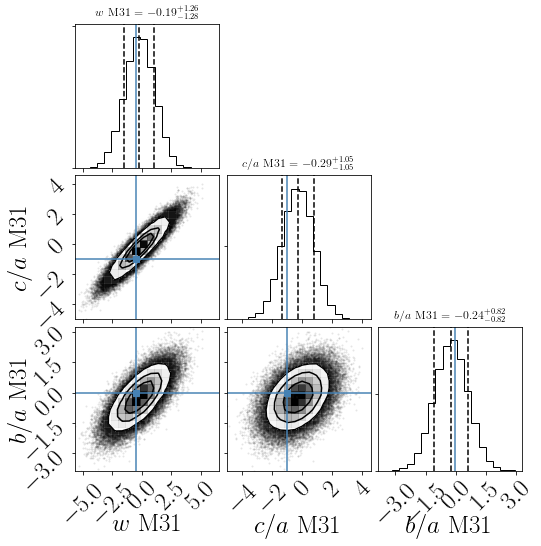

In [14]:
figure = corner.corner(data_random_elvis_M31, 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ M31", r"$c/a$ M31", r"$b/a$ M31"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=M31_obs['data_obs'])
filename = "../paper/gaussian_model_elvis_M31.pdf"
plt.savefig(filename, bbox_inches='tight')

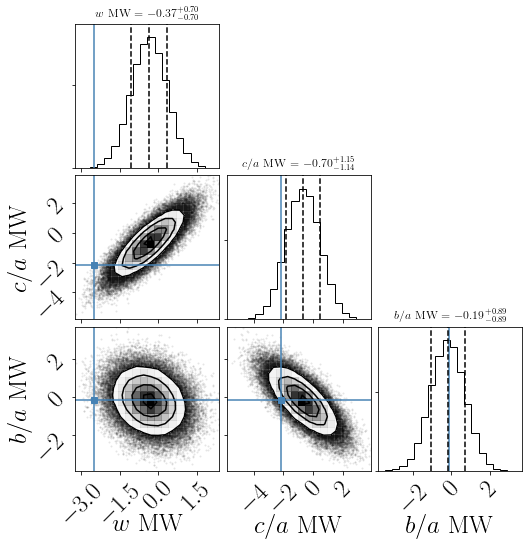

In [15]:
figure = corner.corner(data_random_elvis_MW, 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ MW", r"$c/a$ MW", r"$b/a$ MW"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=MW_obs['data_obs'])
filename = "../paper/gaussian_model_elvis_MW.pdf"
plt.savefig(filename, bbox_inches='tight')

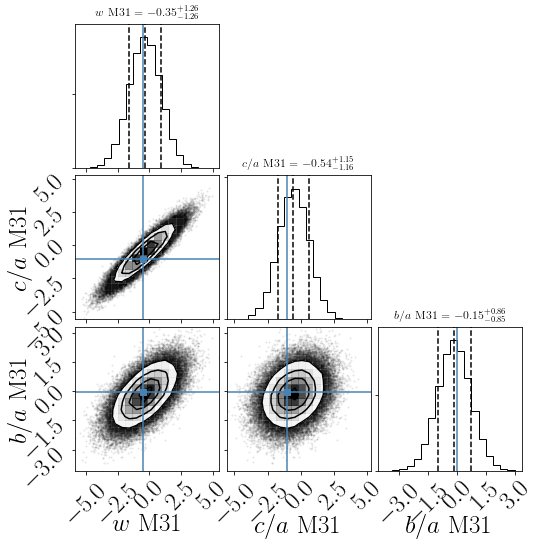

In [16]:
figure = corner.corner(data_random_illustrisdm_M31, 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ M31", r"$c/a$ M31", r"$b/a$ M31"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=M31_obs['data_obs'])
filename = "../paper/gaussian_model_illustrisdm_M31.pdf"
plt.savefig(filename, bbox_inches='tight')

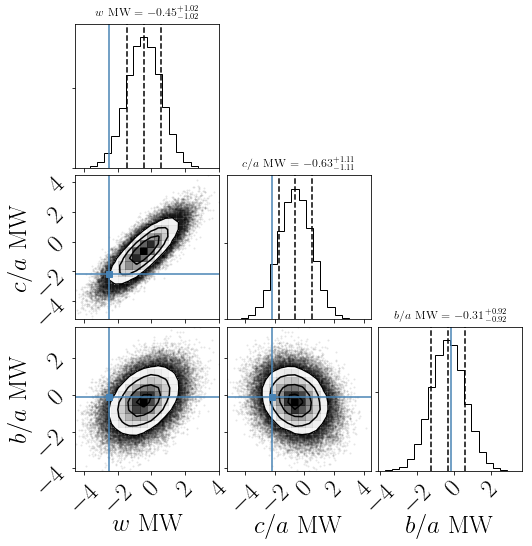

In [17]:
figure = corner.corner(data_random_illustrisdm_MW, 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ MW", r"$c/a$ MW", r"$b/a$ MW"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=MW_obs['data_obs'])
filename = "../paper/gaussian_model_illustrisdm_MW.pdf"
plt.savefig(filename, bbox_inches='tight')

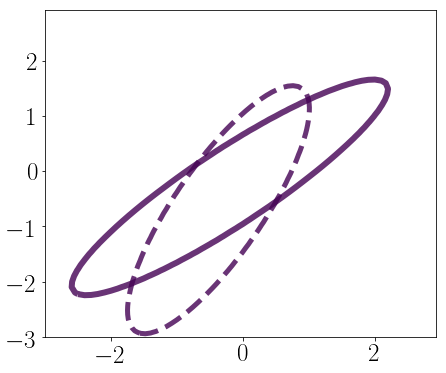

In [18]:
fig = plt.figure(1, figsize=(7,6))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=25)
delta = 0.08
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
#print(np.sqrt(cov_elvis_MW['mean'][0]), cov_elvis_MW['mean'][1], cov_elvis_MW['covariance'][0,1])
#print(cov_elvis_MW['covariance'][0,1]/np.sqrt(cov_elvis_MW['covariance'][0,0] * cov_elvis_MW['covariance'][1,1]))
Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_elvis_MW['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_elvis_MW['covariance'][1,1]), 
                          mux=cov_elvis_MW['mean'][0], muy=cov_elvis_MW['mean'][1], 
                          sigmaxy=cov_elvis_MW['covariance'][0,1])
CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=5, alpha=0.8, linestyles='--')
#im = plt.imshow(-Z, interpolation='bilinear', origin='lower',cmap=cm.gray, extent=(-3, 3, -3, 3), alpha=0.4)


Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_illustris_MW['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_illustris_MW['covariance'][1,1]), 
                          mux=cov_illustris_MW['mean'][0], muy=cov_illustris_MW['mean'][1], 
                          sigmaxy=cov_illustris_MW['covariance'][0,1])
#CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=4, alpha=0.8, linestyles='--')


Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_illustrisdm_MW['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_illustrisdm_MW['covariance'][1,1]), 
                          mux=cov_illustrisdm_MW['mean'][0], muy=cov_illustrisdm_MW['mean'][1], 
                          sigmaxy=cov_illustrisdm_MW['covariance'][0,1])
#CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=2, alpha=0.8, linestyles='--')



delta = 0.10
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
#print(np.sqrt(cov_elvis_MW['mean'][0]), cov_elvis_MW['mean'][1], cov_elvis_MW['covariance'][0,1])
#print(cov_elvis_MW['covariance'][0,1]/np.sqrt(cov_elvis_MW['covariance'][0,0] * cov_elvis_MW['covariance'][1,1]))
Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_elvis_M31['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_elvis_M31['covariance'][1,1]), 
                          mux=cov_elvis_M31['mean'][0], muy=cov_elvis_M31['mean'][1], 
                          sigmaxy=cov_elvis_M31['covariance'][0,1])
CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=6, alpha=0.8)
#im = plt.imshow(-Z, interpolation='bilinear', origin='lower',cmap=cm.gray, extent=(-3, 3, -3, 3), alpha=0.4)

Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_illustris_M31['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_illustris_M31['covariance'][1,1]), 
                          mux=cov_illustris_M31['mean'][0], muy=cov_illustris_M31['mean'][1], 
                          sigmaxy=cov_illustris_M31['covariance'][0,1])
#CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=6, alpha=0.5)

Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov_illustrisdm_M31['covariance'][0,0]), 
                          sigmay=np.sqrt(cov_illustrisdm_M31['covariance'][1,1]), 
                          mux=cov_illustrisdm_M31['mean'][0], muy=cov_illustrisdm_M31['mean'][1], 
                          sigmaxy=cov_illustrisdm_M31['covariance'][0,1])
#CS = plt.contour(X, Y, Z, levels = np.arange(0.05, 0.4, 0.40), linewidths=6, alpha=0.5)

#im = plt.imshow(-Z, interpolation='bilinear', origin='lower',cmap=cm.gray, extent=(-3, 3, -3, 3), alpha=0.4)

In [19]:
print(cov_elvis_MW['covariance'])
print(cov_elvis_MW['covariance_error'])
print(cov_elvis_MW['mean'])
print(cov_elvis_MW['mean_error'])

[[ 0.4951191   0.65997222 -0.13874126]
 [ 0.65997222  1.32163933 -0.75526409]
 [-0.13874126 -0.75526409  0.79570714]]
[[ 0.05794252  0.10935447  0.0678222 ]
 [ 0.10935447  0.18378618  0.09821263]
 [ 0.0678222   0.09821263  0.07346069]]
[-0.3706855  -0.69588125 -0.1937145 ]
[ 0.04743987  0.07750775  0.06014026]


In [20]:
def number_LG(sim_cov_M31, sim_mean_M31, sim_cov_MW, sim_mean_MW, obs_M31, obs_MW, n_sample=20):
    n_try = 1000
    n_out = np.ones(n_try)
    n_MW = np.ones(n_try)
    n_M31 = np.ones(n_try)

    for i in range(n_try):
        sim_M31 = np.random.multivariate_normal(sim_mean_M31, sim_cov_M31, size=n_sample)
        sim_MW = np.random.multivariate_normal(sim_mean_MW, sim_cov_MW, size=n_sample)
        
        like_M31_from_M31 = sim_M31[:,0]<1E6
        like_MW_from_MW = sim_MW[:,0]<1E6
        for j in range(3):
            like_M31_from_M31 &= (np.abs(sim_M31[:,j]-sim_mean_M31[j]) > np.abs(obs_M31[j]-sim_mean_M31[j]))
            like_MW_from_MW &= (np.abs(sim_MW[:,j]-sim_mean_MW[j]) > np.abs(obs_MW[j]-sim_mean_MW[j]))
        #print(sim_M31[like_M31_from_M31,:])
        
        n_out[i] = np.count_nonzero(like_M31_from_M31 & like_MW_from_MW)
        n_MW[i] = np.count_nonzero(like_MW_from_MW)
        n_M31[i] = np.count_nonzero(like_M31_from_M31)
        #print(n_M31[i])
    return {'n_LG': n_out, 'n_MW':n_MW, 'n_M31':n_M31}

In [21]:
n_out_list_elvis = number_LG(cov_elvis_M31['covariance'], cov_elvis_M31['mean'],
             cov_elvis_MW['covariance'], cov_elvis_MW['mean'],
             M31_obs['data_obs'], MW_obs['data_obs'], n_sample=10000)
n_out_list_illustris = number_LG(cov_illustris_M31['covariance'], cov_illustris_M31['mean'],
             cov_illustris_MW['covariance'], cov_illustris_MW['mean'],
             M31_obs['data_obs'], MW_obs['data_obs'], n_sample=10000)
n_out_list_illustrisdm = number_LG(cov_illustrisdm_M31['covariance'], cov_illustrisdm_M31['mean'],
             cov_illustrisdm_MW['covariance'], cov_illustrisdm_MW['mean'],
             M31_obs['data_obs'], MW_obs['data_obs'], n_sample=10000)

In [34]:
plt.figure(figsize=(10,7))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=20)

n_MW IllustrisDM: 318.84+-17.77251811083618
n_MW Illustris: 60.26+-7.996774349698758
n_MW Elvis: 24.616+-4.9153376282815


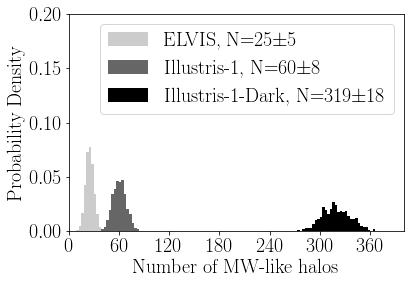

In [36]:
min_number = {'n_M31':2500, 'n_MW':0}
max_number = {'n_M31':6200, 'n_MW': 400}
delta_number = {'n_M31':50, 'n_MW': 3}
yrange = {'n_M31':0.025, 'n_MW':0.20}
name = {'n_M31':'M31', 'n_MW': 'MW'}
field_number = 'n_MW'

mean_LG_illustris = np.mean(n_out_list_illustris[field_number])
std_LG_illustris = np.std(n_out_list_illustris[field_number])

mean_LG_illustrisdm = np.mean(n_out_list_illustrisdm[field_number])
std_LG_illustrisdm = np.std(n_out_list_illustrisdm[field_number])

mean_LG_elvis = np.mean(n_out_list_elvis[field_number])
std_LG_elvis = np.std(n_out_list_elvis[field_number])

print("{} IllustrisDM: {}+-{}".format(field_number, mean_LG_illustrisdm, std_LG_illustrisdm)) 
print("{} Illustris: {}+-{}".format(field_number, mean_LG_illustris, std_LG_illustris)) 
print("{} Elvis: {}+-{}".format(field_number, mean_LG_elvis, std_LG_elvis))


a = plt.hist(n_out_list_elvis[field_number], bins=np.arange(0,max_number[field_number],delta_number[field_number]), 
             normed=True, label=r'ELVIS, N={:.0f}$\pm${:.0f}'.format(mean_LG_elvis, std_LG_elvis), 
             alpha=0.2, color='black')

a = plt.hist(n_out_list_illustris[field_number], bins=np.arange(0,max_number[field_number],delta_number[field_number]), 
             normed=True, label=r'Illustris-1, N={:.0f}$\pm${:.0f}'.format(mean_LG_illustris, std_LG_illustris),  
             alpha=0.6, color='black')

a = plt.hist(n_out_list_illustrisdm[field_number], bins=np.arange(0,max_number[field_number],delta_number[field_number]), 
             normed=True, label=r'Illustris-1-Dark, N={:.0f}$\pm${:.0f}'.format(mean_LG_illustrisdm, std_LG_illustrisdm),  
             alpha=1.0, color='black')

plt.legend()
plt.xlabel('Number of {}-like halos'.format(name[field_number]))
plt.ylabel('Probability Density')
a = plt.xticks(np.arange(0,max_number[field_number],20*delta_number[field_number]))
plt.xlim([min_number[field_number],max_number[field_number]])
plt.ylim([0,yrange[field_number]])
#plt.title("Matched Probability Distributions")

filename = "../paper/expected_numbers_{}.pdf".format(field_number)
plt.savefig(filename, bbox_inches='tight')

In [37]:
def print_stats(field_number):
    mean_LG_illustris = np.mean(n_out_list_illustris[field_number])
    std_LG_illustris = np.std(n_out_list_illustris[field_number])

    mean_LG_illustrisdm = np.mean(n_out_list_illustrisdm[field_number])
    std_LG_illustrisdm = np.std(n_out_list_illustrisdm[field_number])

    mean_LG_elvis = np.mean(n_out_list_elvis[field_number])
    std_LG_elvis = np.std(n_out_list_elvis[field_number])

    print("{} IllustrisDM: {}+-{}".format(field_number, mean_LG_illustrisdm, std_LG_illustrisdm)) 
    print("{} Illustris: {}+-{}".format(field_number, mean_LG_illustris, std_LG_illustris)) 
    print("{} Elvis: {}+-{}".format(field_number, mean_LG_elvis, std_LG_elvis))
    print("")

In [38]:
print_stats('n_LG')
print_stats('n_MW')
print_stats('n_M31')

n_LG IllustrisDM: 181.428+-13.250766619331879
n_LG Illustris: 16.22+-3.9721027177050696
n_LG Elvis: 9.022+-3.085695383539989

n_MW IllustrisDM: 318.84+-17.77251811083618
n_MW Illustris: 60.26+-7.996774349698758
n_MW Elvis: 24.616+-4.9153376282815

n_M31 IllustrisDM: 5688.456+-51.00292211236528
n_M31 Illustris: 2719.869+-44.23790048137457
n_M31 Elvis: 3707.218+-48.97842868038949

